In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import data_preparation as data_prep
from AirNormalizer import AirNormalizer
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
import datetime as dt

plt.rcParams['figure.figsize'] = [10, 7]
path = "../data/tmp/"

# Analisi degli effetti del traffico sugli inquinanti
Avere a disposizione un modello che ci permette di eliminare l'influenza delle condizioni meteorologiche e della variabilità stagionale dalle concentrazioni degli inquinanti atmosferici ci permette di poter fare delle analisi più precise sull'efficacia di misure prese per contrastare l'inquinamento. L'andamento delle serie normalizzate, infatti, deve per forza essere causato da fattori non considerati nella loro generazione. Sicuramente i due più importanti sono: l'eventuale trend rilevato per le concentrazioni, che noi ovviamente non andiamo ad eliminare poichè è quello che ci interessa per monitorarne l'andamento, ed altri fattori che possono avere un'influenza e che non sono stati considerati, quindi ad esempio particolari situazioni in cui le emissioni antropiche sono state ridotte (COVID) o nuove normative messe in campo.

Quando si parla di inquinamento atmosferico uno degli aspetti su cui sicuramente il dibattito è più acceso e che attira più interesse è l'influenza del traffico veicolare sulla qualità dell'aria. Spesso infatti si sente additare il traffico come il principale responsabile delle concentrazioni degli inquinanti più preoccupanti (e, salvo gli ossidi di azoto, questa cosa non è vera) e sempre maggiori nel corso degli anni sono stati i provvedimenti presi nelle grandi città atti a ridurre il traffico, in nome di una migliore qualità dell'aria. Questi provvedimenti sono stati sempre molto contestati e dibattuti, poichè molti ritengono che il traffico non sia la causa principale dell'inquinamento e che la soluzione non sia bloccarlo ma studiare alternative per renderlo il più "efficiente" possibile (meno traffico, parcheggi, ecc..).

In questo notebook proveremo quindi ad usare la nostra tecnica per verificare quali siano i risultati ottenuti in seguito all'applicazione di alcuni provvedimenti sul traffico presi nella città di Milano nel corso degli ultimi anni, in modo da mostrare come l'applicazione di tecniche per normalizzare i dati dell'inquinamento rispetto alla meteorologia permetta uno studio migliore dell'efficacia delle misure prese nell'abbattimento delle concentrazioni. Purtroppo la mancanza di dati relativi a velocità e direzione del vento, due misure (specialmente la prima) a cui di solito viene assegnata una discreta importanza dai nostri modelli, ci costringe a limitare le nostre analisi al periodo successivo al 2012. Cosi facendo possiamo quindi controllare l'andamento delle concentrazioni a partire dall'introduzione di Area C, anche se sarebbe stato interessante avere a disposizione anche dati degli anni precedenti, in modo da poter fare un confronto più esteso che coinvolgesse anche gli anni precedenti all'introduzione del provvedimento.  
Per verificare eventuali effetti derivanti dall'introduzione di questi provvedimenti andremo quindi a confrontare l'andamento della serie normalizzata ottenuta per la stazione di Milano Via Senato, coinvolta appunto dal provvedimento Area C, con quelli delle serie di altre due stazioni: quella di Pioltello Limito, situata nell'hinterland milanese, e quella di Bormio, che si trova in un ambiente molto diverso da quello cittadino. La prima è stata scelta poichè, essendo comunque vicina alla città, la qualità dell'aria e le condizioni che la determinano dovrebbero essere abbastanza simili. Non essendo stata colpita da nessun provvedimento, inoltre, ci permette di avere una base di confronto per verificare se appunto l'applicazione di misure come Area C possa effettivamente aver portato a qualche risultato. La stazione di Bormio invece presenta caratteristiche completamente differenti, ma è comunque utile provare a verificare eventuali analogie o discrepanze tra le serie, per vedere quali siano le differenze tra due località così diverse.

Come sempre quando vogliamo trattare le serie normalizzate il primo passaggio da fare è la preparazione dei dati da usare. La funzione prepare_data() si occupa di preparare i dati necessari alla creazione dei modelli, di creare tali modelli e di generare le serie normalizzate, salvando tutto su dei file di appoggio che ci permetteranno di velocizzare l'esecuzione del notebook le volte successive.  
Il pezzo di codice successivo recupera i dati da tali file e ci prepara le strutture necessarie per il proseguimento delle nostre analisi.

In [2]:
def prepare_data():
    milano_nox_data = data_prep.prepare_data(6354,2001,2006,14390,14391,2002,2008)
    milano_no2_data = data_prep.prepare_data(5551,2001,2006,14390,14391,2002,2008)
    milano_co_data = data_prep.prepare_data(5834,2001,2006,14390,14391,2002,2008)
    milano_pm10_data = data_prep.prepare_data(10320,2001,2006,14390,14391,2002,2008)

    limito_nox_data = data_prep.prepare_data(6324,2001,2006,14390,14391,2002,2008)
    limito_no2_data = data_prep.prepare_data(5534,2001,2006,14390,14391,2002,2008)
    limito_co_data = data_prep.prepare_data(5825,2001,2006,14390,14391,2002,2008)
    limito_pm10_data = data_prep.prepare_data(6908,2001,2006,14390,14391,2002,2008)
    
    bormio_nox_data = data_prep.prepare_data(6374,13,11,19394,19393,19389,19397)
    bormio_no2_data = data_prep.prepare_data(5574,13,11,19394,19393,19389,19397)
    bormio_co_data = data_prep.prepare_data(5842,13,11,19394,19393,19389,19397)
    bormio_pm10_data = data_prep.prepare_data(6925,13,11,19394,19393,19389,19397)
    
    milano_nox_data.to_csv(path + "Milano_6354_NOX.csv")
    milano_no2_data.to_csv(path + "Milano_5551_NO2.csv")
    milano_co_data.to_csv(path + "Milano_5834_CO.csv")
    milano_pm10_data.to_csv(path + "Milano_10320_PM10.csv")
    limito_nox_data.to_csv(path + "Limito_6324_NOX.csv")
    limito_no2_data.to_csv(path + "Limito_5534_NO2.csv")
    limito_co_data.to_csv(path + "Limito_5825_CO.csv")
    limito_pm10_data.to_csv(path + "Limito_6908_PM10.csv")
    bormio_nox_data.to_csv(path + "Bormio_6374_NOX.csv")
    bormio_no2_data.to_csv(path + "Bormio_5574_NO2.csv")
    bormio_co_data.to_csv(path + "Bormio_5842_CO.csv")
    bormio_pm10_data.to_csv(path + "Bormio_6925_PM10.csv")
    
    milano_nox_normalizer = AirNormalizer(milano_nox_data)
    milano_no2_normalizer = AirNormalizer(milano_no2_data)
    milano_co_normalizer = AirNormalizer(milano_co_data)
    milano_pm10_normalizer = AirNormalizer(milano_pm10_data)
    milano_nox_norm = milano_nox_normalizer.normalize_timeseries()
    milano_no2_norm = milano_no2_normalizer.normalize_timeseries()
    milano_co_norm = milano_co_normalizer.normalize_timeseries(n_preds=300)
    milano_pm10_norm = milano_pm10_normalizer.normalize_timeseries(n_preds=300)
    milano_nox_norm.to_csv(path + "Milano_6354_NOX_normalizzato.csv")
    milano_no2_norm.to_csv(path + "Milano_5551_NO2_normalizzato.csv")
    milano_co_norm.to_csv(path + "Milano_5834_CO_normalizzato.csv")
    milano_pm10_norm.to_csv(path + "Milano_10320_PM10_normalizzato.csv")
    
    limito_nox_normalizer = AirNormalizer(limito_nox_data)
    limito_no2_normalizer = AirNormalizer(limito_no2_data)
    limito_co_normalizer = AirNormalizer(limito_co_data)
    limito_pm10_normalizer = AirNormalizer(limito_pm10_data)
    limito_nox_norm = limito_nox_normalizer.normalize_timeseries()
    limito_no2_norm = limito_no2_normalizer.normalize_timeseries()
    limito_co_norm = limito_co_normalizer.normalize_timeseries()
    limito_pm10_norm = limito_pm10_normalizer.normalize_timeseries()
    limito_nox_norm.to_csv(path + "Limito_6324_NOX_normalizzato.csv")
    limito_no2_norm.to_csv(path + "Limito_5534_NO2_normalizzato.csv")
    limito_co_norm.to_csv(path + "Limito_5825_CO_normalizzato.csv")
    limito_pm10_norm.to_csv(path + "Limito_6908_PM10_normalizzato.csv")
    
    bormio_nox_normalizer = AirNormalizer(bormio_nox_data)
    bormio_no2_normalizer = AirNormalizer(bormio_no2_data)
    bormio_co_normalizer = AirNormalizer(bormio_co_data)
    bormio_pm10_normalizer = AirNormalizer(bormio_pm10_data)
    bormio_nox_norm = bormio_nox_normalizer.normalize_timeseries()
    bormio_no2_norm = bormio_no2_normalizer.normalize_timeseries()
    bormio_co_norm = bormio_co_normalizer.normalize_timeseries()
    bormio_pm10_norm = bormio_pm10_normalizer.normalize_timeseries()
    bormio_nox_norm.to_csv(path + "Bormio_6374_NOX_normalizzato.csv")
    bormio_no2_norm.to_csv(path + "Bormio_5574_NO2_normalizzato.csv")
    bormio_co_norm.to_csv(path + "Bormio_5842_CO_normalizzato.csv")
    bormio_pm10_norm.to_csv(path + "Bormio_6925_PM10_normalizzato.csv")
    
#prepare_data()
    
milano_nox_data = pd.read_csv(path + "Milano_6354_NOX.csv", parse_dates=["Data"], index_col="Data")
milano_no2_data = pd.read_csv(path + "Milano_5551_NO2.csv", parse_dates=["Data"], index_col="Data")
milano_co_data = pd.read_csv(path + "Milano_5834_CO.csv", parse_dates=["Data"], index_col="Data")
milano_pm10_data = pd.read_csv(path + "Milano_10320_PM10.csv", parse_dates=["Data"], index_col="Data")

limito_nox_data = pd.read_csv(path + "Limito_6324_NOX.csv", parse_dates=["Data"], index_col="Data")
limito_no2_data = pd.read_csv(path + "Limito_5534_NO2.csv", parse_dates=["Data"], index_col="Data")
limito_co_data = pd.read_csv(path + "Limito_5825_CO.csv", parse_dates=["Data"], index_col="Data")
limito_pm10_data = pd.read_csv(path + "Limito_6908_PM10.csv", parse_dates=["Data"], index_col="Data")

bormio_nox_data = pd.read_csv(path + "Bormio_6374_NOX.csv", parse_dates=["Data"], index_col="Data")
bormio_no2_data = pd.read_csv(path + "Bormio_5574_NO2.csv", parse_dates=["Data"], index_col="Data")
bormio_co_data = pd.read_csv(path + "Bormio_5842_CO.csv", parse_dates=["Data"], index_col="Data")
bormio_pm10_data = pd.read_csv(path + "Bormio_6925_PM10.csv", parse_dates=["Data"], index_col="Data")

milano_nox_normalizer = AirNormalizer(milano_nox_data)
milano_no2_normalizer = AirNormalizer(milano_no2_data)
milano_co_normalizer = AirNormalizer(milano_co_data)
milano_pm10_normalizer = AirNormalizer(milano_pm10_data)
milano_nox_norm = pd.read_csv(path + "Milano_6354_NOX_normalizzato.csv", parse_dates=["Data"], index_col="Data")
milano_no2_norm = pd.read_csv(path + "Milano_5551_NO2_normalizzato.csv", parse_dates=["Data"], index_col="Data")
milano_co_norm = pd.read_csv(path + "Milano_5834_CO_normalizzato.csv", parse_dates=["Data"], index_col="Data")
milano_pm10_norm = pd.read_csv(path + "Milano_10320_PM10_normalizzato.csv", parse_dates=["Data"], index_col="Data")

limito_nox_normalizer = AirNormalizer(limito_nox_data)
limito_no2_normalizer = AirNormalizer(limito_no2_data)
limito_co_normalizer = AirNormalizer(limito_co_data)
limito_pm10_normalizer = AirNormalizer(limito_pm10_data)
limito_nox_norm = pd.read_csv(path + "Limito_6324_NOX_normalizzato.csv", parse_dates=["Data"], index_col="Data")
limito_no2_norm = pd.read_csv(path + "Limito_5534_NO2_normalizzato.csv", parse_dates=["Data"], index_col="Data")
limito_co_norm = pd.read_csv(path + "Limito_5825_CO_normalizzato.csv", parse_dates=["Data"], index_col="Data")
limito_pm10_norm = pd.read_csv(path + "Limito_6908_PM10_normalizzato.csv", parse_dates=["Data"], index_col="Data")

bormio_nox_normalizer = AirNormalizer(bormio_nox_data)
bormio_no2_normalizer = AirNormalizer(bormio_no2_data)
bormio_co_normalizer = AirNormalizer(bormio_co_data)
bormio_pm10_normalizer = AirNormalizer(bormio_pm10_data)
bormio_nox_norm = pd.read_csv(path + "Bormio_6374_NOX_normalizzato.csv", parse_dates=["Data"], index_col="Data")
bormio_no2_norm = pd.read_csv(path + "Bormio_5574_NO2_normalizzato.csv", parse_dates=["Data"], index_col="Data")
bormio_co_norm = pd.read_csv(path + "Bormio_5842_CO_normalizzato.csv", parse_dates=["Data"], index_col="Data")
bormio_pm10_norm = pd.read_csv(path + "Bormio_6925_PM10_normalizzato.csv", parse_dates=["Data"], index_col="Data")

## NOX e NO2
### NOX 
Quando si parla di traffico e si vuole analizzare il suo impatto sulla qualità dell'aria gli inquinanti di maggiore interesse sono sicuramente gli ossidi di azoto, di cui questa categoria risulta responsabile per il 50% delle emissioni secondo quanto riportato da [INEMAR 2017](https://www.inemar.eu/xwiki/bin/view/InemarDatiWeb/Inventario+delle+emissioni+in+atmosfera).  

Quando si parla degli ossidi di azoto relativamente al traffico l'attenzione viene posta maggiormente sul diesel, che è il maggior responsabile delle emissioni di questo inquinante. Nel corso degli ultimi anni il numero dei veicoli con motorizzazione diesel circolanti in Italia è andato sempre ad aumentare, tanto che [IIR2020](http://www.sinanet.isprambiente.it/it/sia-ispra/serie-storiche-emissioni/informative-inventory-report/view) stima un consumo quasi triplo di carburante per quanto riguarda veicoli diesel rispetto a quelli a benzina.  Questo aumento di veicoli circolanti avrebbe dovuto aver l'effetto di innalzare le concentrazioni di ossidi di azoto misurate, ma è stato contrastato dall'innovazione tecnologica che è riuscita sempre di più a ridurre le emissioni prodotte (basti pensare alle categorie EuroX), introducendo importanti invenzioni come ad esempio la marmitta catalitica.

Quando avevamo analizzato in precedenza l'andamento della media tra le serie dei capoluoghi di provincia Lombardi avevamo ottenuto un andamento abbastanza costante nel corso degli ultimi 15 anni, con un leggero trend calante negli anni più recenti. Sembra quindi che anche per la Lombardia l'aumento dei veicoli circolanti motorizzati a diesel sia stato contrastato dal progresso tecnologico, che ha permesso di mantenere le concentrazioni sotto controllo.

Proviamo quindi a creare tre modelli per questo inquinante, uno per ogni località scelta per il nostro esperimento, e verifichiamo come negli anni si siano evolute le diverse situazioni.

In [3]:
print("MILANO:")
print(milano_nox_normalizer.evaluate_testing())
print("=======================================")
print("LIMITO")
print(limito_nox_normalizer.evaluate_testing())
print("=======================================")
print("BORMIO")
print(bormio_nox_normalizer.evaluate_testing())

MILANO:
MSE     1058.564068
RMSE      32.535582
R2         0.770370
dtype: float64
LIMITO
MSE     2786.490330
RMSE      52.787217
R2         0.734126
dtype: float64
BORMIO
MSE     100.217064
RMSE     10.010847
R2        0.730254
dtype: float64


I modelli ottenuti hanno tutti buone performance, che ci consentono quindi di affrontare le analisi potendoci fidare con una certa confidenza dei risultati ottenuti.
Il modello di Bormio presenta una particolarità interessante: il valore dell'$RMSE$ (l'errore medio commesso nelle previsioni del nostro modello) è molto minore rispetto a quanto ottenuto per le altre due località.

Andiamo ora ad analizzare l'importanza delle variabili per i tre modelli, in modo da poter controllare se tra le diverse località esistano delle differenze che potrebbero far pensare a diverse dinamiche che governano l'andamento delle concentrazioni.

In [4]:
print("MILANO:")
print(milano_nox_normalizer.feature_importance())
print("=======================================")
print("LIMITO")
print(limito_nox_normalizer.feature_importance())
print("=======================================")
print("BORMIO")
print(bormio_nox_normalizer.feature_importance())

MILANO:
                   cols       imp
0           temperatura  0.301533
3        velocita_vento  0.218782
6           day_of_year  0.149348
5            radiazione  0.113733
8                 epoch  0.065743
4               umidita  0.039138
2       direzione_vento  0.033518
1        precipitazioni  0.031229
7           day_of_week  0.027984
9  giorni_senza_pioggia  0.018993
LIMITO
                   cols       imp
3        velocita_vento  0.284357
0           temperatura  0.274085
6           day_of_year  0.141527
5            radiazione  0.082907
8                 epoch  0.065685
2       direzione_vento  0.045735
4               umidita  0.035917
1        precipitazioni  0.028286
7           day_of_week  0.023508
9  giorni_senza_pioggia  0.017994
BORMIO
                   cols       imp
3        velocita_vento  0.342676
5            radiazione  0.190500
0           temperatura  0.135697
4               umidita  0.106742
6           day_of_year  0.097028
8                 epoch  0

Innanzitutto possiamo notare come per tutte e tre le località la velocità del vento sia una variabile a cui viene assegnata una buona importanza, se non addirittura la maggiore come nei casi di Limito e Bormio. Per quest'ultima stazione, addirittura, l'importanza risulta di gran lunga più alta rispetto a tutte le altre variabili. In realtà se pensiamo alle sue caratteristiche geografiche la cosa non dovrebbe sorprenderci più di tanto, poichè è evidente come in una valle montana l'azione del vento abbia una funzione dispersiva ancora più importante che in altre località.  
L'altra variabile che in tutti e tre i casi viene riconosciuta come buon predittore risulta essere la temperatura, che può essere utile per verificare sia l'andamento stagionale che possibili eventi meteorologici particolari che possono portare ad un aumento delle emissioni antropiche (ad esempio periodi particolarmente freddi in cui vengono maggiormente usati riscaldamenti e automezzi rispetto a quando si registrano temperature più miti).

Terminate queste analisi preliminari possiamo andare a controllare gli andamenti delle serie normalizzate per le tre stazioni.

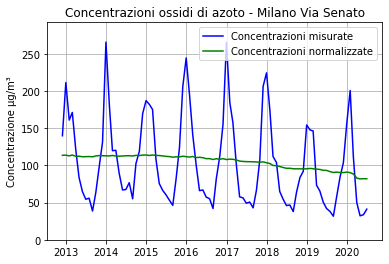

In [5]:
medie = milano_nox_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = milano_nox_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni ossidi di azoto - Milano Via Senato")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

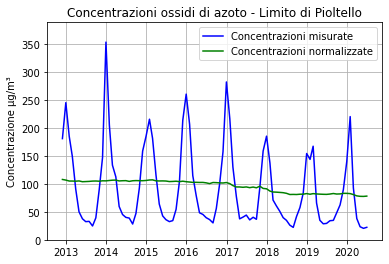

In [6]:
medie = limito_nox_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = limito_nox_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni ossidi di azoto - Limito di Pioltello")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Da questo primo confronto possiamo subito notare come entrambe le serie presentino dei risultati abbastanza simili, con valori leggermente minori per quanto riguarda quella di Limito, sia per quanto riguada le concentrazioni normalizzate ottenute che per l'andamento delle due serie. Si note in entrambe, infatti, come dal 2017 si sia iniziato a registrare un leggero trend decrescente.

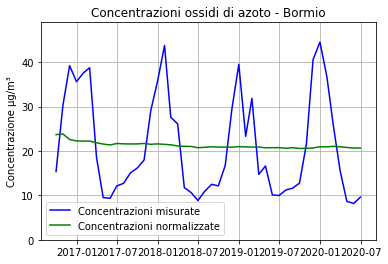

In [7]:
medie = bormio_nox_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = bormio_nox_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni ossidi di azoto - Bormio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Purtroppo per quanto riguarda la stazione di Bormio si hanno a disposizione solo i dati degli ultimi 3 anni, e quindi le analisi che potremo fare risultano piuttosto limitate. Ho comunque scelto di continuare ad usarla nei nostri confronti, nonostante questo problema, poichè può comunque essere utile per comprendere come sia la situazione in una località con caratteristiche completamente differenti rispetto a quelle cittadine.  
Per quanto riguarda gli ossidi di azoto vediamo come le concentrazioni registrate siano decisamente minori rispetto a quanto visto per le altre due località. L'andamento risulta essere piuttosto costante, anche se la ridotta estensione temporale della serie considerata non ci permette di fare alcuna considerazione in merito.

Proviamo ora a confrontare gli andamenti delle tre stazioni tramite un grafico in cui vengono anche riportate le date di inizio dei due provvedimenti principali presi nel corso degli ultimi anni per limitare il traffico all'interno della città di Milano: Area C e Area B.
In questo modo se l'introduzione di tali misure ha portato a dei reali effetti di abbattimento delle concentrazioni dovremmo essere in grado di notarli.

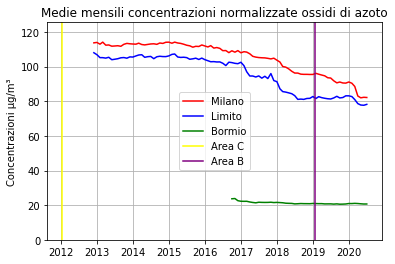

In [8]:
milano_nox_mesenorm = milano_nox_norm.groupby(pd.Grouper(freq="M")).mean()
limito_nox_mesenorm = limito_nox_norm.groupby(pd.Grouper(freq="M")).mean()
bormio_nox_mesenorm = bormio_nox_norm.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_nox_mesenorm.inquinante), max(limito_nox_mesenorm.inquinante), max(bormio_nox_mesenorm.inquinante)])

plt.plot(milano_nox_mesenorm.index, milano_nox_mesenorm.inquinante, "-r", label="Milano")
plt.plot(limito_nox_mesenorm.index, limito_nox_mesenorm.inquinante, "-b", label="Limito")
plt.plot(bormio_nox_mesenorm.index, bormio_nox_mesenorm.inquinante, "-g", label="Bormio")
#plt.axvline(dt.datetime(2008,1,1), color="orange", label="Ecopass")
plt.axvline(dt.datetime(2012,1,16), color="yellow", label="Area C")
plt.axvline(dt.datetime(2019,1,21), color="purple", label="Area B")
plt.title("Medie mensili concentrazioni normalizzate ossidi di azoto")
plt.ylabel("Concentrazioni µg/m³")
plt.ylim(0, max_y + (max_y / 10))
plt.legend()
plt.grid()
plt.show()

Guardando il grafico generato si nota innanzitutto come la serie di Bormio abbia davvero dei valori ridotti che ci mostrano come in località di questo tipo l'inquinamento da ossidi di azoto non sia sicuramente un problema.  
Un altro aspetto che risalta subito all'occhio è l'andamento pressochè identico delle serie relative a Milano e Limito, che mostrano entrambe come a partire dal 2016/2017 si sia registrato un trend decrescente praticamente compatibile tra le due stazioni. Analizzando solo la serie di Milano avremmo potuto pensare che questo calo potesse essere collegato alla riduzione del traffico causata dai provvedimenti presi, ma osservare lo stesso andamento anche su una stazione diversa e non colpita da tali limitazioni ci indica che la causa deve per forza essere un'altra. Una possibile idea è che l'origine di questo trend sia proprio nell'innovazione tecnologica, i cui risultati stanno finalmente mettendosi in mostra nonostante le sempre maggiori attività umane, portando a registrare un calo generale e non specifico di alcune località. A Bormio, dove sicuramente la densità di attività antropiche inquinanti è nettamente ridotta rispetto alle altre due stazioni, questo calo risulta chiaramente molto minore, sia appunto perchè gli effetti dell'innovazione possono essere meno evidenti a causa della minor applicazione che perchè le concentrazioni sono già molto ridotte e quindi è ancora più difficile far registrare dei cali consistenti.

### NO2
Per completezza è giusto trattare anche il biossido di azoto, inquinante sempre molto collegato al traffico e attorno al quale c'è molto interesse per i possibili effetti sulla salute umana.

Anche in questo caso partiamo verificando le perfomance dei modelli delle tre località, che solitamente sono abbastanza in linea con quelle dei modelli per gli ossidi.

In [9]:
print("MILANO:")
print(milano_no2_normalizer.evaluate_testing())
print("=======================================")
print("LIMITO")
print(limito_no2_normalizer.evaluate_testing())
print("=======================================")
print("BORMIO")
print(bormio_no2_normalizer.evaluate_testing())

MILANO:
MSE     84.456608
RMSE     9.190028
R2       0.751667
dtype: float64
LIMITO
MSE     86.076933
RMSE     9.277766
R2       0.785668
dtype: float64
BORMIO
MSE     21.304222
RMSE     4.615650
R2       0.787217
dtype: float64


Vengono ancora una volta confermate le buone performance dei modelli già viste in precedenza, che ci consentono quindi di analizzare i risultati ottenuti con una buona confidenza.

Verifichiamo anche l'importanza delle variabili di ciascun modello.

In [10]:
print("MILANO:")
print(milano_no2_normalizer.feature_importance())
print("=======================================")
print("LIMITO")
print(limito_no2_normalizer.feature_importance())
print("=======================================")
print("BORMIO")
print(bormio_no2_normalizer.feature_importance())

MILANO:
                   cols       imp
0           temperatura  0.258446
3        velocita_vento  0.176054
8                 epoch  0.148627
6           day_of_year  0.133005
5            radiazione  0.093292
7           day_of_week  0.051699
4               umidita  0.044798
2       direzione_vento  0.042474
1        precipitazioni  0.027002
9  giorni_senza_pioggia  0.024604
LIMITO
                   cols       imp
0           temperatura  0.265368
3        velocita_vento  0.216573
8                 epoch  0.126178
6           day_of_year  0.119103
5            radiazione  0.070435
2       direzione_vento  0.060709
1        precipitazioni  0.043347
4               umidita  0.039993
9  giorni_senza_pioggia  0.033564
7           day_of_week  0.024731
BORMIO
                   cols       imp
3        velocita_vento  0.293831
0           temperatura  0.198046
5            radiazione  0.188139
6           day_of_year  0.115461
4               umidita  0.064783
8                 epoch  0

Anche qui vediamo confermate velocità del vento e temperatura come misure più importanti, per le stesse ragioni viste in precedenza.

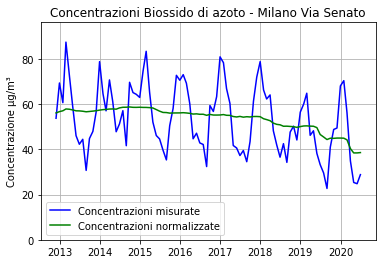

In [11]:
medie = milano_no2_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = milano_no2_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni Biossido di azoto - Milano Via Senato")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

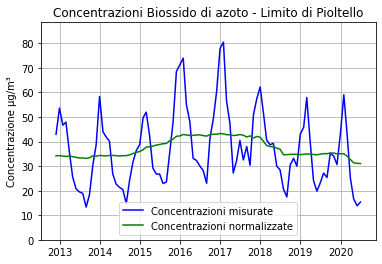

In [12]:
medie = limito_no2_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = limito_no2_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni Biossido di azoto - Limito di Pioltello")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

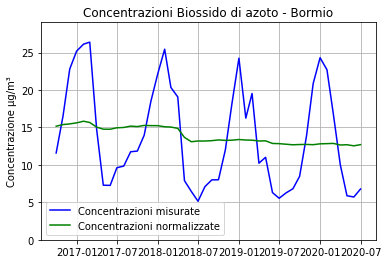

In [13]:
medie = bormio_no2_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = bormio_no2_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni Biossido di azoto - Bormio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

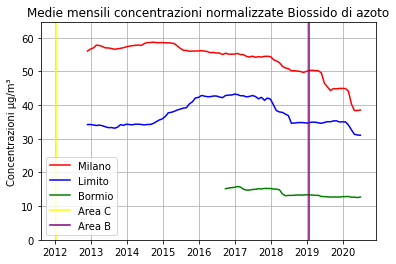

In [14]:
milano_no2_mesenorm = milano_no2_norm.groupby(pd.Grouper(freq="M")).mean()
limito_no2_mesenorm = limito_no2_norm.groupby(pd.Grouper(freq="M")).mean()
bormio_no2_mesenorm = bormio_no2_norm.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_no2_mesenorm.inquinante), max(limito_no2_mesenorm.inquinante), max(bormio_no2_mesenorm.inquinante)])

plt.plot(milano_no2_mesenorm.index, milano_no2_mesenorm.inquinante, "-r", label="Milano")
plt.plot(limito_no2_mesenorm.index, limito_no2_mesenorm.inquinante, "-b", label="Limito")
plt.plot(bormio_no2_mesenorm.index, bormio_no2_mesenorm.inquinante, "-g", label="Bormio")
#plt.axvline(dt.datetime(2008,1,1), color="orange", label="Ecopass")
plt.axvline(dt.datetime(2012,1,16), color="yellow", label="Area C")
plt.axvline(dt.datetime(2019,1,21), color="purple", label="Area B")
plt.title("Medie mensili concentrazioni normalizzate Biossido di azoto")
plt.ylabel("Concentrazioni µg/m³")
plt.ylim(0, max_y + (max_y / 10))
plt.legend()
plt.grid()
plt.show()

In questo caso notiamo una sostanziale differenza tra l'andamento delle serie di Milano e Limito. La prima, in modo abbastanza compatibile con quanto già visto per gli ossidi di azoto, mostra un trend decrescente a partire dagli ultimi cinque anni. Per la seconda, invece, tra gli anni 2015 e 2018 si è assistito ad un aumento delle concentrazioni, che prima si mantenevano su un livello abbastanza stabile, che sono tornare a riscendere nel corso degli ultimi due anni. È proprio negli stessi anni in cui la serie normalizzata fa registrare questo aumnento che proprio in quella zona è stata inaugurata l'autostrada BreBeMi, che potrebbe aver portato ad un aumento del flusso di traffico e conseguentemente delle concentrazioni registrate. Andrebbe però verificato per quale motivo a seguito del 2018 sembra che le concentrazioni tornino sul livello più o meno costante visto tra il 2012 ed il 2014.  
Per quanto riguarda la situazione di Milano sembra che effettivamente la qualità dell'aria sia migliorata nel corso degli anni, potenzialmente anche grazie alla riduzione del traffico causata da Area C prima ed Area B poi. Se questa è sicuramente una potenziale causa è anche vero che probabilmente a contribuire ai ribassamenti c'è un trend di fondo, dettato da fattori come l'innovazione tecnologica, che infatti sembra parzialmente verificato anche per Pioltello (almeno a seguito del 2018) che per Bormio.  

Nel caso degli ossidi di azoto, quindi, sembra che le misure prese a Milano abbiano portato a qualche miglioramento, specialmente per quanto riguarda il biossido, per il quale le serie normalizzate di Milano e Limito presentano andamenti diversi, al contrario di quello che si era visto trattando gli ossidi.

## CO 
Per quanto riguarda il monossido di carbonio INEMAR 2017 individua trasporto su strada e combustioni non industriali (quindi i riscaldamenti, in particolare quelli alimentati a biomasse) come le due principali fonti emissive, con un percentuale di circa il 60% del totale.  

La situazione per quanto riguarda questo inquinante non risulta essere critica, visto che le concentrazioni registrare sono ormai prossime a valori riconducibili al fondo naturale. Nonostante ciò ritengo sia comunque utile fare un'analisi di questo tipo, sia per verificare eventuali effetti dei provvedimenti di limitazione al traffico presi, che per provare a cercare eventuali differenze tra le serie delle tre località. In questo caso risulta particolarmente interessante indagare anche su quella di Bormio, poichè è una zona in cui la legna viene ancora molto usata come forma di riscaldamento e quindi si possono indagare su quali siano gli effetti di questi "comportamenti".

Chiaramente il primo passo da compiere è la creazione dei modelli, in modo da poterne verificare e confrontare le performance.

In [15]:
print("MILANO:")
print(milano_co_normalizer.evaluate_testing())
print("=======================================")
print("LIMITO")
print(limito_co_normalizer.evaluate_testing())
print("=======================================")
print("BORMIO")
print(bormio_co_normalizer.evaluate_testing())

MILANO:
MSE     0.039753
RMSE    0.199382
R2      0.747752
dtype: float64
LIMITO
MSE     0.014587
RMSE    0.120775
R2      0.799299
dtype: float64
BORMIO
MSE     0.010763
RMSE    0.103744
R2      0.799745
dtype: float64


Le prestazioni dei tre modelli risultano buone, anche migliori rispetto a quanto ottenuto con gli ossidi di azoto. È sicuramente curioso notare come, in questo caso, il modello della stazione di Milano risulti essere quello con le prestazioni peggiori (ma comunque buone e che ci confermano la possibilità di usare i dati di tale modello per compiere le nostre analisi).

Vedimao se possiamo notare differenze sull'importanza delle variabili per i tre modelli.

In [16]:
print("MILANO:")
print(milano_co_normalizer.feature_importance())
print("=======================================")
print("LIMITO")
print(limito_co_normalizer.feature_importance())
print("=======================================")
print("BORMIO")
print(bormio_co_normalizer.feature_importance())

MILANO:
                   cols       imp
8                 epoch  0.254539
0           temperatura  0.203930
3        velocita_vento  0.150284
6           day_of_year  0.132400
5            radiazione  0.090140
4               umidita  0.052750
2       direzione_vento  0.043508
1        precipitazioni  0.025892
9  giorni_senza_pioggia  0.025255
7           day_of_week  0.021305
LIMITO
                   cols       imp
0           temperatura  0.349828
3        velocita_vento  0.213216
6           day_of_year  0.121117
8                 epoch  0.116054
5            radiazione  0.075193
2       direzione_vento  0.048120
4               umidita  0.034900
9  giorni_senza_pioggia  0.014940
1        precipitazioni  0.014504
7           day_of_week  0.012128
BORMIO
                   cols       imp
5            radiazione  0.197686
0           temperatura  0.195370
8                 epoch  0.188453
6           day_of_year  0.126305
3        velocita_vento  0.124351
4               umidita  0

La variabile con importanza maggiore nei tre modelli è sicuramente la temperatura, che ci permette proprio di cogliere l'andamento tipicamente stagionale di questo inquinante. Inoltre, essendo derivante in buona parte dai riscaldamenti domestici, è abbastanza evidente come tale misura possa essere utilizzata per stimarne un loro utilizzo e quindi riuscire a fare previsioni più precise e che sappiano considerare anche questo aspetto.  
La velocità del vento, chiaramente, risulta avere ancora una buona importanza, che ci conferma nuovamente la forte azione dispersiva di questo elemento.  
Per quanto riguarda il modello di Bormio vediamo che la radiazione globale risulta essere la variabile con importanza maggiore, al pari della temperatura. Anche per essa e per il collegamento con la presenza di sole (e quindi il possibile uso di riscaldamenti) e la stagionalità è naturale che valga lo stesso discorso fatto per la temperatura.

Procediamo ora con l'analisi delle serie normalizzate ottenute per ciascuna località.

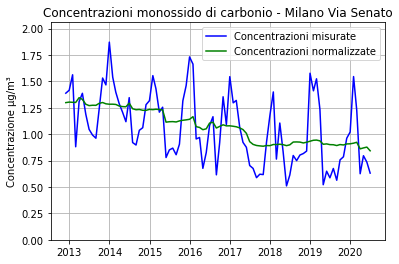

In [17]:
medie = milano_co_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = milano_co_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni monossido di carbonio - Milano Via Senato")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

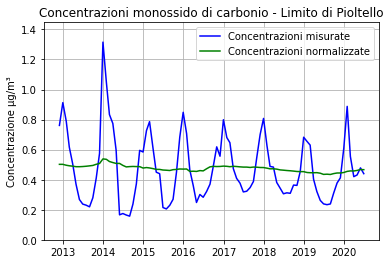

In [18]:
medie = limito_co_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = limito_co_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni monossido di carbonio - Limito di Pioltello")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

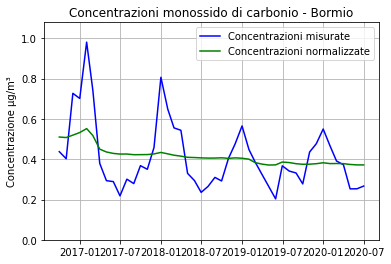

In [19]:
medie = bormio_co_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = bormio_co_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni monossido di carbonio - Bormio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

L'andamento della serie risulta essere abbastanza costante ed in linea con quanto già visto per la stazione di Limito. 

Ripetiamo il confronto delle tre serie fatto in precedenza, per verificare eventuali differenze sugli andamenti che possano essere collegate a provvedimenti paritcolari messi in atto.

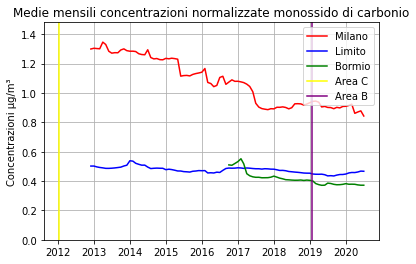

In [20]:
milano_co_mesenorm = milano_co_norm.groupby(pd.Grouper(freq="M")).mean()
limito_co_mesenorm = limito_co_norm.groupby(pd.Grouper(freq="M")).mean()
bormio_co_mesenorm = bormio_co_norm.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_co_mesenorm.inquinante), max(limito_co_mesenorm.inquinante), max(bormio_co_mesenorm.inquinante)])

plt.plot(milano_co_mesenorm.index, milano_co_mesenorm.inquinante, "-r", label="Milano")
plt.plot(limito_co_mesenorm.index, limito_co_mesenorm.inquinante, "-b", label="Limito")
plt.plot(bormio_co_mesenorm.index, bormio_co_mesenorm.inquinante, "-g", label="Bormio")
#plt.axvline(dt.datetime(2008,1,1), color="orange", label="Ecopass")
plt.axvline(dt.datetime(2012,1,16), color="yellow", label="Area C")
plt.axvline(dt.datetime(2019,1,21), color="purple", label="Area B")
plt.title("Medie mensili concentrazioni normalizzate monossido di carbonio")
plt.ylabel("Concentrazioni µg/m³")
plt.ylim(0, max_y + (max_y / 10))
plt.legend()
plt.grid()
plt.show()

Se le stazioni di Limito e Bormio presentavano valori già molto bassi e con un andamento costante, per la stazione di Milano possiamo vedere che nel corso degli ultimi anni si sia registrato un calo abbastanza importante delle concentrazioni. Attualmente i valori risultano ancora più alti rispetto a quelli delle altre due località, potenzialmente anche a causa della maggior densità abitativa (e quindi un maggiore uso di veicoli e riscaldamenti) della città rispetto alle altre due zone.  
L'origine di questo calo potrebbe sicuramente essere in parte collegata i provvedimenti di limitazione del traffico, come potrebbe venire il sospetto guardando il grafico, poichè viene registrato solo per la stazione di Milano e non sulle altre due (a differenza di quanto visto in precedenza dove il calo risultava essere compatibile su tutte le località). Altre possibili ragioni potrebbero essere i provvedimenti di limitazione all'uso di riscaldamenti a biomasse nelle città presi nel corso degli ultimi anni, anche se il loro effetto probabilmente si sarebbe visto, anche solo parzialmente, anche sulle serie delle altre località, in particolare quella di Limito che è stata soggetta alle stesse limitazioni.

## PM10 
Le polveri sottili sono sempre un inquinante molto discusso e che spesso viene (anche erroneamente) collegato al traffico. Secondo INEMAR 2017 il traffico risulta essere responsabile di meno del 25% delle emissioni di PM10, mentre il settore principale risultano ancora essere le combustioni non industriali, specialmente per quanto riguarda i riscaldamenti a biomasse. Avendo una composizione molto varia è comunque difficile stabilire in modo preciso l'origine del particolato atmosferico e quindi quali sono le fonti di maggiori emissioni.   
Una cosa che però è bene ricordare quando si parla di polveri sottili e traffico è che gli unici responsabili di questo inquinante per questo settore sono i motori a diesel, poichè quelli a benzina non lo producono (ed infatti non viene limitato nemmeno dalle categorie EuroX).

Negli ultimi anni c'è stata molta attenzione riguardo a questo inquinante, specialmente per gli effetti che ha sulla salute umana.  
Questo ha quindi portato anche molto interesse nella ricerca di soluzioni efficaci per il loro contenimento, che per quanto riguarda il traffico sono state individuate nell'uso di filtri antiparticolato che riducano le emissioni al tubo di scappamento.  

Andiamo ora a verificare le performance dei modelli creati per le tre località relativamente a questo inquinante.

In [21]:
print("MILANO:")
print(milano_pm10_normalizer.evaluate_testing())
print("=======================================")
print("LIMITO")
print(limito_pm10_normalizer.evaluate_testing())
print("=======================================")
print("BORMIO")
print(bormio_pm10_normalizer.evaluate_testing())

MILANO:
MSE     158.720455
RMSE     12.598431
R2        0.701808
dtype: float64
LIMITO
MSE     230.807863
RMSE     15.192362
R2        0.625296
dtype: float64
BORMIO
MSE     26.377940
RMSE     5.135946
R2       0.585904
dtype: float64


Notiamo anche in questo caso come le performance dei modelli relativi alle polveri sottili siano sempre minori rispetto a quelle viste per altri inquinanti. Nonostante ciò i risultati ottenuti sono abbastanza buoni e ci permettono comunque di provare a fare delle analisi con i risultati ottenuti.

Analizziamo ora l'importanza delle variabili nei tre modelli.

In [22]:
print("MILANO:")
print(milano_pm10_normalizer.feature_importance())
print("=======================================")
print("LIMITO")
print(limito_pm10_normalizer.feature_importance())
print("=======================================")
print("BORMIO")
print(bormio_pm10_normalizer.feature_importance())

MILANO:
                   cols       imp
3        velocita_vento  0.277386
0           temperatura  0.173043
6           day_of_year  0.136109
4               umidita  0.086119
5            radiazione  0.081794
9  giorni_senza_pioggia  0.067528
1        precipitazioni  0.059214
8                 epoch  0.054867
2       direzione_vento  0.044900
7           day_of_week  0.019039
LIMITO
                   cols       imp
3        velocita_vento  0.310898
0           temperatura  0.170263
6           day_of_year  0.140553
5            radiazione  0.082402
8                 epoch  0.065334
4               umidita  0.064131
9  giorni_senza_pioggia  0.057584
1        precipitazioni  0.049026
2       direzione_vento  0.041575
7           day_of_week  0.018233
BORMIO
                   cols       imp
3        velocita_vento  0.271903
0           temperatura  0.227320
6           day_of_year  0.117831
4               umidita  0.087309
5            radiazione  0.085915
8                 epoch  0

Vediamo come per tutte e tre le località le tre variabili più importanti siano le stesse: velocità del vento, temperatura e giorno dell'anno. Anche in questo caso è abbastanza naturale che sia così, viste le dinamiche che regolano l'andamento di questo inquinante. **RIVEDI**

Procediamo ora con l'analisi delle serie normalizzate.

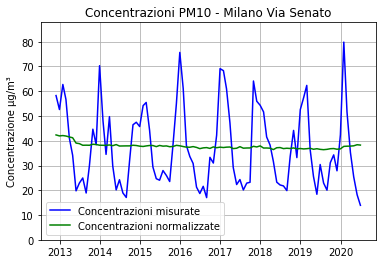

In [23]:
medie = milano_pm10_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = milano_pm10_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni PM10 - Milano Via Senato")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

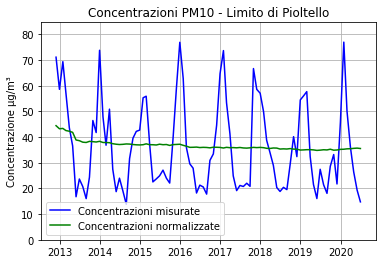

In [24]:
medie = limito_pm10_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = limito_pm10_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni PM10 - Limito di Pioltello")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Le serie normalizzate ottenute per la stazione di Milano e quella di Limito risultano essere praticamente identiche, sia per i valori calcolati che per l'andamento leggermente decrescente ottenuto.

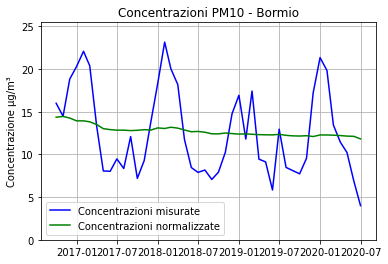

In [25]:
medie = bormio_pm10_data.groupby(pd.Grouper(freq="M")).mean()
medie_norm = bormio_pm10_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante)
plt.plot(medie.index, medie.inquinante, color="blue", label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, color="green", label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Concentrazioni PM10 - Bormio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Anche per la stazione di Bormio si registra un trend leggermente calante, anche se questa volta le concentrazioni normalizzate calcolate hanno valori decisamente più bassi rispetto alle due località precedenti. Questo fatto comunque non ci stupisce, vista la differenza tra le località considerate.

Ripetiamo quanto fatto in precedenza per valutare i provvedimenti di limitazione del traffico imposti a Milano.

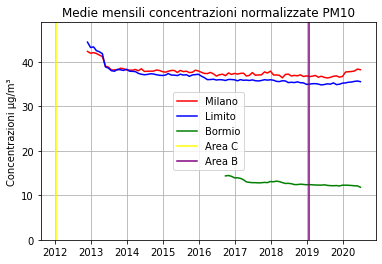

In [26]:
milano_pm10_mesenorm = milano_pm10_norm.groupby(pd.Grouper(freq="M")).mean()
limito_pm10_mesenorm = limito_pm10_norm.groupby(pd.Grouper(freq="M")).mean()
bormio_pm10_mesenorm = bormio_pm10_norm.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_pm10_mesenorm.inquinante), max(limito_pm10_mesenorm.inquinante), max(bormio_pm10_mesenorm.inquinante)])

plt.plot(milano_pm10_mesenorm.index, milano_pm10_mesenorm.inquinante, "-r", label="Milano")
plt.plot(limito_pm10_mesenorm.index, limito_pm10_mesenorm.inquinante, "-b", label="Limito")
plt.plot(bormio_pm10_mesenorm.index, bormio_pm10_mesenorm.inquinante, "-g", label="Bormio")
#plt.axvline(dt.datetime(2008,1,1), color="orange", label="Ecopass")
plt.axvline(dt.datetime(2012,1,16), color="yellow", label="Area C")
plt.axvline(dt.datetime(2019,1,21), color="purple", label="Area B")
plt.title("Medie mensili concentrazioni normalizzate PM10")
plt.ylabel("Concentrazioni µg/m³")
plt.ylim(0, max_y + (max_y / 10))
plt.legend()
plt.grid()
plt.show()

Vediamo come l'andamento delle tre serie, sebbena quella di Bormio stia su valori molto minori, sia assolutamente compatibile con una grande similitudine tra quella di Milano e quella di Limito e vista la natura del particolato, che viene trasportato anche per grandi distanze, la cosa comunque non ci stupisce. In questo caso si vede come non si possa notare alcuna differenza tra gli andamenti delle serie che ci possa suggerire una reale efficacia dei provvedimenti presi in termini di limitazione del traffico. Anzi, guardando il grafico ottenuto, la serie di Limito (non coinvolto da nessuna misura) risulta calata leggermente di più rispetto a quella di Milano.  
Il trend presentato è calante ma i valori sono sicuramente ancora molto vicini al limite imposto per legge e questa potrebbe essere un'indicazione della necessità di misure di diverso tipo per contrastare questo inquinante, che dovranno necessariamente coinvolgere i settori maggiormente responsabili delle emissioni e non solamente il traffico.

## Dataset ingressi area C
L'algoritmo random forest ha il grande vantaggio di poter sempre provare ad introdurre nuove variabili predittrici per i nostri modelli senza doverci preoccupare di problemi come la correlazione o la collinearità, come invece succede con metodi come la regressione lineare. Infatti, in fase di costruzione, sarà proprio il modello stesso a scegliere quali variabili usare maggiormente per fare previsioni, scegliendo di volta in volta quelle che portano ad avere previsioni più accurate.  

Per indagare ulteriormente sugli effetti del traffico sulle concentrazioni degli inquinanti potremmo quindi provare ad introdurre una variabile che tracci appunto il numero di veicoli circolanti, in modo quindi da costruire dei modelli che siano in grado di eliminare l'influenza del traffico dalle concentrazioni, in maniera analoga a quanto fatto con tutte le altre misure predittrici scelte.  
Per fare questo vengono in nostro soccorso i [dataset](https://dati.comune.milano.it/organization/comunedimilano?q=area+C&sort=score+desc%2C+metadata_modified+desc) pubblicati dal comune di Milano con le registrazioni degli ingressi in AreaC. Tramite un apposito script abbiamo quindi recuperato i dati anche di tale dataset, organizzati in appositi file e usati poi nella preparazione dei dati su cui basare la costruzione del nostro modello. Cosi facendo abbiamo ottenuto un modello in grado di eliminare l'effetto del traffico dalle concentrazioni, restituendoci una serie che rappresenti quale sarebbe stata la concentrazione in una giornata con condizioni meteorologiche, stagionali e del traffico medie. Questa serie potrà poi essere confrontata con quelle generate dai modelli creati senza la variabile del traffico per cercare possibili discrepanze, che potrebbero appunto indicarci come l'effetto del traffico abbia pesato sulle concentrazioni registrate.

Passiamo quindi alla creazione di questo nuovo modello per utilizzarlo nell'analisi degli inquinanti trattati in precedenza.

### NOX

In [27]:
#ossidi di azoto - Milano via Senato
#nox_areac = data_prep.prepare_data(6354,2001,2006,14390,14391,2002,2008, use_areac=True)
#nox_areac.to_csv(path + "Milano_6354_NOX_areac.csv")

nox_areac = pd.read_csv(path + "Milano_6354_NOX_areac.csv", parse_dates=["Data"], index_col="Data")

Ora che abbiamo a disposizione la tabella con inclusi i dati degli ingressi in Area C possiamo provare a controllarne l'andamento per cercare di farci un'idea sul quadro della situazione generale.

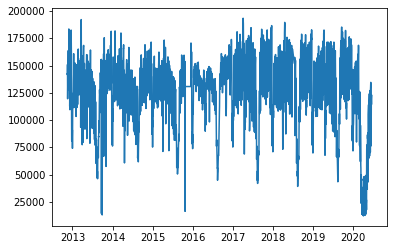

In [28]:
plt.plot(nox_areac.index, nox_areac.ingressi_areac)
plt.show()

Vediamo come nel corso degli anni l'andamento sia sempre stato piuttosto costante, mostrando un andamento ciclico caratterizzato da un calo, prevedibile, nei mesi estivi.  
Si può chiaramente notare l'effetto lockdown, che ha portato ad avere il traffico a livelli molto più bassi di quanto mai visto in precedenza.  
Nel corso degli anni, fatta eccezione per la particolare primavera di quest'anno, l'influenza del traffico sulle concentrazioni dovrebbe essere rimasta piuttosto invariata, anche se l'ammodernamento della flotta circolante potrebbe sicuramente aver ridotto le emissioni totali, anche a parità di veicoli circolanti.

Passiamo ora alla creazione del modello ed alla verifica delle sue prestazioni.

In [29]:
nox_areac_normalizer = AirNormalizer(nox_areac)
print(nox_areac_normalizer.evaluate_training())
print(nox_areac_normalizer.evaluate_testing())

MSE          189.732675
RMSE          13.774348
OOB Score      0.761649
dtype: float64
MSE     1027.889398
RMSE      32.060714
R2         0.777024
dtype: float64


Le prestazioni del modello ottenuto sono in linea con quelle ottenute senza l'inclusione della variabile sul traffico. Questa misura, quindi, non ci permette di fare previsioni più precise di quanto non riuscissimo già a fare, ma ciò non significa che non potrebbero esserci delle differenze nelle serie normalizzate che otterremo.  

Controlliamo anche l'importanza delle variabili per vedere quanta viene attribuita agli ingressi in Area C.

In [30]:
nox_areac_normalizer.feature_importance()

,cols,imp
0,temperatura,0.273334
3,velocita_vento,0.227880
7,day_of_year,0.125032
5,radiazione,0.120290
6,ingressi_areac,0.075408
9,epoch,0.053027
4,umidita,0.035777
2,direzione_vento,0.028928
1,precipitazioni,0.027252
8,day_of_week,0.018664


Alla variabile viene attribuita un'importanza media, che significa che viene abbastanza utilizzata per fare previsioni. L'importanza delle altre variabili del modello risulta invece praticamente invariata, con temperatura e velocità del vento che continuano ad essere le due più importanti.  

Uno strumento utile per verificare come il nostro modello utilizzi le variabili predittrici per fare previsioni sono i partial dependence plots. Come già visto in precedenza questi grafici ci mostrano come vari il valore delle previsioni fatte dal nostro modello al variare del valore di una singola variabile, con tutte le altre fissate al loro valore medio.  
Analizziamo quindi il grafico riguardante la variabile del traffico per vedere come il nostro modello ne faccia uso.

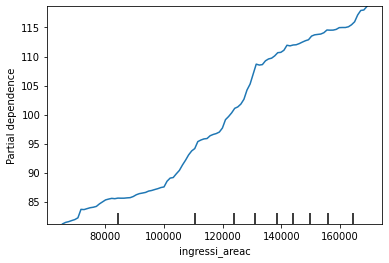

In [31]:
plot_partial_dependence(nox_areac_normalizer.get_model(), nox_areac_normalizer.get_trainingset(), ["ingressi_areac"])

Non sorprendentemente, visto il forte collegamento tra questi inquinanti ed il traffico, si vede come le previsioni del nostro modello arrivino ad avere valori decisamente maggiori al crescere del numero di ingressi registrati, con un aumento di oltre 30µg/m³ se si raddoppia il numero di ingressi.  
Il fatto che il nostro modello sia stato capace di individuare questa relazione ci dà confidenza sul fatto che sarà anche poi capace di eliminarla durante la generazione della serie normalizzata.

Andiamo proprio a controllare questa serie, confrontandola con quella ricavata dai modelli usati in precedenza, cercando eventuali differenze.

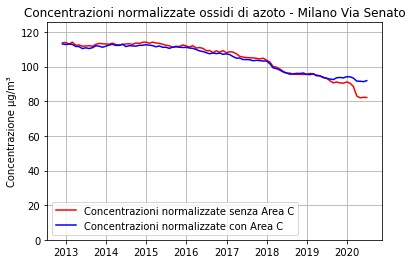

In [32]:
#milano_nox_norm_areac = nox_areac_normalizer.normalize_timeseries()
#milano_nox_norm_areac.to_csv(path + "Milano_6354_NOX_areac_normalizzato.csv")
milano_nox_norm_areac = pd.read_csv(path + "Milano_6354_NOX_areac_normalizzato.csv", parse_dates=["Data"], index_col="Data")

milano_nox_mesenorm_areac = milano_nox_norm_areac.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_nox_mesenorm.inquinante), max(milano_nox_mesenorm_areac.inquinante)])

plt.plot(milano_nox_mesenorm.index, milano_nox_mesenorm.inquinante, color="red", label="Concentrazioni normalizzate senza Area C")
plt.plot(milano_nox_mesenorm_areac.index, milano_nox_mesenorm_areac.inquinante, color="blue", label="Concentrazioni normalizzate con Area C")
plt.title("Concentrazioni normalizzate ossidi di azoto - Milano Via Senato")
plt.ylabel("Concentrazione µg/m³")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

A primo impatto si nota subito come le due serie siano sempre praticamente equivalenti, mantenendo lo stesso andamento. Si nota anche, però, come per il 2020 le due serie mostrino andamenti molto diversi, con una differenza di circa 10 µg/m³ sulle concentrazioni previste.  
Come avevamo visto in precedenza è proprio nel 2020 che il traffico ha fatto registrare un importante calo, dovuto alle misure per il contenimento dei contagi da COVID, e si nota chiaramente come in corrispondenza di questo calo le previsioni dei due modelli siano discordanti.  
Da un lato si vede come il modello costruito senza l'uso del numero di ingressi registrati in Area C abbia effettivamente rilevato un calo abbastanza importante nelle concentrazioni misurate, dovuto proprio alla diminuzione del traffico. Dall'altro si vede invece come il modello costruito usando anche i dataset di Area C non rilevi questa differenza, continuando a mantenere un andamento in linea col trend decrescente di questi ultimi anni. Questo modello, infatti, essendo stato costruito utilizzando anche i dati sul traffico è capace di eliminarne l'influenza (e ciò avviene sia in condizioni di traffico al di sopra che al di sotto della media) e rapportando i dati dei mesi della primavera 2020 a condizioni di traffico medie ha eliminato il calo rilevato in precedenza.  Questo ci dà ulteriormente conferma dell'origine da attribuire a tale calo ed inoltre ci dà una stima di come mediamente potrebbero cambiare le concentrazioni se venisse completamente (o quasi, proprio come è successo nei mesi di lockdown) eliminato il traffico veicolare.  

Per quanto riguarda gli NOX abbiamo quindi dimostrato come effettivamente anche i nostri modelli siano in grado di individuare l'influenza del traffico sulle concentrazioni e abbiamo provato anche a quantificare il possibile miglioramento della qualità dell'aria che si otterrebbe eliminandolo completamente.  
Un'altra nota da fare è che i modelli creati utilizzando anche i dati degli ingressi in Area C individuano comunque lo stesso trend decrescente nelle concentrazioni già visto in precedenza, mostrandoci quindi come questo andamento non sia associabile al volume del traffico, ma che le sue cause siano da ricercare altrove. Una delle possibilità più probabili è sicuramente che l'innovazione tecnologica, e quindi il calo delle emissioni, abbiano determinato questo calo.

### NO2
Per completezza proviamo a trattare anche il biossido di azoto con la stessa tecnica.

In [33]:
#Biossido di azoto - Milano via Senato
#no2_areac = data_prep.prepare_data(5551,2001,2006,14390,14391,2002,2008, use_areac=True)
#no2_areac.to_csv(path + "Milano_5551_NOX_areac.csv")

no2_areac = pd.read_csv(path + "Milano_5551_NOX_areac.csv", parse_dates=["Data"], index_col="Data")

In [34]:
no2_areac_normalizer = AirNormalizer(no2_areac)
print(no2_areac_normalizer.evaluate_training())
print(no2_areac_normalizer.evaluate_testing())

MSE          14.218898
RMSE          3.770795
OOB Score     0.723032
dtype: float64
MSE     83.038887
RMSE     9.112568
R2       0.755835
dtype: float64


In [35]:
no2_areac_normalizer.feature_importance()

,cols,imp
0,temperatura,0.229578
3,velocita_vento,0.179261
6,ingressi_areac,0.150816
9,epoch,0.107749
5,radiazione,0.095335
7,day_of_year,0.084265
4,umidita,0.037805
2,direzione_vento,0.037491
8,day_of_week,0.031115
1,precipitazioni,0.025460


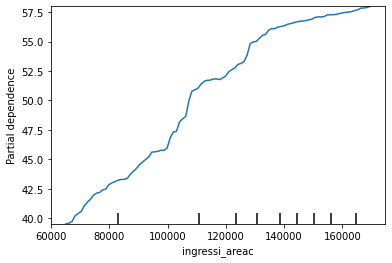

In [36]:
plot_partial_dependence(no2_areac_normalizer.get_model(), no2_areac_normalizer.get_trainingset(), ["ingressi_areac"])

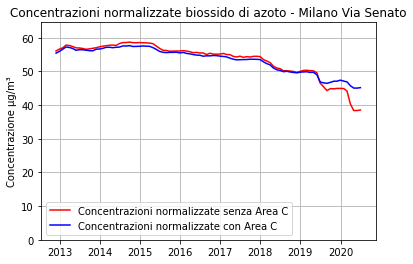

In [37]:
milano_no2_norm_areac = no2_areac_normalizer.normalize_timeseries()
milano_no2_norm_areac.to_csv(path + "Milano_5551_NO2_areac_normalizzato.csv")
milano_no2_norm_areac = pd.read_csv(path + "Milano_5551_NO2_areac_normalizzato.csv", parse_dates=["Data"], index_col="Data")

milano_no2_mesenorm_areac = milano_no2_norm_areac.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_no2_mesenorm.inquinante), max(milano_no2_mesenorm_areac.inquinante)])

plt.plot(milano_no2_mesenorm.index, milano_no2_mesenorm.inquinante, color="red", label="Concentrazioni normalizzate senza Area C")
plt.plot(milano_no2_mesenorm_areac.index, milano_no2_mesenorm_areac.inquinante, color="blue", label="Concentrazioni normalizzate con Area C")
plt.title("Concentrazioni normalizzate biossido di azoto - Milano Via Senato")
plt.ylabel("Concentrazione µg/m³")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Anche per questo inquinante valgono le stesse considerazioni fatte per gli ossidi. Importante notare come anche questa volta ci sia una differenza di andamento per l'anno 2020 associabile proprio al calo del traffico circolante dovuto al lockdown.

### CO  
Procediamo le nostre analisi trattando il monossido di carbonio, altro inquinante collegato al traffico e di cui le concentrazioni ne sono sicuramente influenzate.  

Creiamo un modello costruito utilizzando anche i dati degli ingressi in Area C e valutiamone le prestazioni.

In [38]:
#monossido di carbonio - Milano via Senato
#co_areac = data_prep.prepare_data(5834,2001,2006,14390,14391,2002,2008, use_areac=True)
#co_areac.to_csv(path + "Milano_5834_CO_areac.csv")

co_areac = pd.read_csv(path + "Milano_5834_CO_areac.csv", parse_dates=["Data"], index_col="Data")

In [39]:
co_areac_normalizer = AirNormalizer(co_areac)
print(co_areac_normalizer.evaluate_training())
print(co_areac_normalizer.evaluate_testing())

MSE          0.006852
RMSE         0.082779
OOB Score    0.713598
dtype: float64
MSE     0.039987
RMSE    0.199968
R2      0.746266
dtype: float64


Anche in questo caso vediamo come le prestazioni del modello ottenuto siano praticamente invariate rispetto a quanto visto in precedenza.

Controlliamo l'importanza che viene associata alla variabile degli ingressi.

In [40]:
co_areac_normalizer.feature_importance()

,cols,imp
9,epoch,0.233705
0,temperatura,0.184538
3,velocita_vento,0.150817
7,day_of_year,0.119861
5,radiazione,0.094254
6,ingressi_areac,0.060794
4,umidita,0.048634
2,direzione_vento,0.041052
1,precipitazioni,0.024946
10,giorni_senza_pioggia,0.022865


L'importanza non è elevatissima, ma la variabile risulta comunque utile per fare previsioni.

Proviamo a controllare il partial dependence plot anche per questo inquinante.

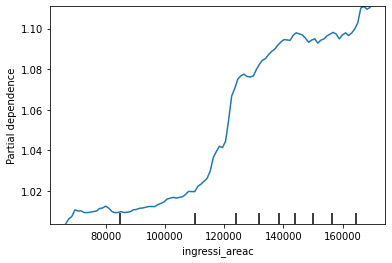

In [41]:
plot_partial_dependence(co_areac_normalizer.get_model(), co_areac_normalizer.get_trainingset(), ["ingressi_areac"])

Anche se l'aumento rilevato al raddoppiare del traffico non è sicuramente consistente come quelli riguardanti gli ossidi di azoto, anche in questo caso possiamo notare come il nostro modello associ una crescita delle concentrazioni al crescere del traffico.  

Passiamo al confronto della serie normalizzata ricavata da questo modello per confrontarla con quella ottenuta in precedenza e verificare come il traffico possa influire sulle concentrazioni di monossido di carbonio.

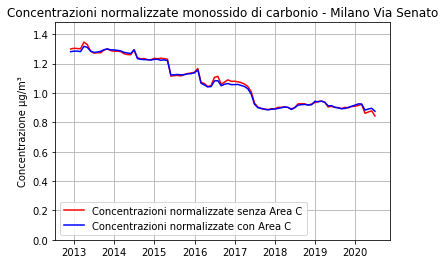

In [42]:
#milano_co_norm_areac = co_areac_normalizer.normalize_timeseries()
#milano_co_norm_areac.to_csv(path + "Milano_5834_CO_areac_normalizzato.csv")
milano_co_norm_areac = pd.read_csv(path + "Milano_5834_CO_areac_normalizzato.csv", parse_dates=["Data"], index_col="Data")

milano_co_mesenorm_areac = milano_co_norm_areac.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_co_mesenorm.inquinante), max(milano_co_mesenorm_areac.inquinante)])

plt.plot(milano_co_mesenorm.index, milano_co_mesenorm.inquinante, color="red", label="Concentrazioni normalizzate senza Area C")
plt.plot(milano_co_mesenorm_areac.index, milano_co_mesenorm_areac.inquinante, color="blue", label="Concentrazioni normalizzate con Area C")
plt.title("Concentrazioni normalizzate monossido di carbonio - Milano Via Senato")
plt.ylabel("Concentrazione µg/m³")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Guardando il grafico si nota nuovamente come le serie ottenute siano sempre piuttosto equivalenti. Ci sono due piccole discrepanze sui risultati ottenuti, una riguardante il periodo dell'epidemia di COVID ed una a cavallo tra gli anni 2016 e 2017.  
Per il periodo riguardante l'epidemia di COVID si nota la stessa situazione vista per gli ossidi di azoto, con il modello costruito senza i dati di Area C che fa previsioni leggermente più basse rispetto all'altro, potenzialmente collegabili alla diminuzione del traffico. Per quanto riguarda il periodo tra il 2016 ed il 2017 si vede invece come le previsioni di tale modello siano più alte, come se l'influenza del traffico in tale periodo sia stata maggiore. Controllando il grafico del numero di ingressi visto in precedenza, però, non si notano aumenti nel numero di veicoli circolanti che possano giustificare tale differenza, quindi le cause potrebbero essere altre oppure si potrebbe semplicemente trattare di una differnza delle previsioni dei due modelli che comunque può esserci, trattandosi di previsioni basate su modelli statistici e che quindi hanno una certa variabilità.  
Trattandosi comunque entrambe di diffrenze minime è difficile stabilire con certezza le cause che stanno alla loro origine.

Per il monossido di carbonio, quindi, l'influenza del traffico sembra essere davvero minima, anche perchè si sta comunque parlando di concentrazioni molto basse. L'innovazione tecnologica del mondo delle auto ha fatto sì che questo inquinante ormai non sia più un effettivo problema.

### PM10
Proviamo ad analizzare le concentrazioni di PM10 per verificare anche nel caso di questo inquinante quale possa essere l'influenza del traffico.

In [43]:
#pm10 - Milano via Senato
#pm10_areac = data_prep.prepare_data(10320,2001,2006,14390,14391,2002,2008, use_areac=True)
#pm10_areac.to_csv(path + "Milano_10320_PM10_areac.csv")

pm10_areac = pd.read_csv(path + "Milano_10320_PM10_areac.csv", parse_dates=["Data"], index_col="Data")

In [44]:
pm10_areac_normalizer = AirNormalizer(pm10_areac)
print(pm10_areac_normalizer.evaluate_training())
print(pm10_areac_normalizer.evaluate_testing())

MSE          25.130593
RMSE          5.013042
OOB Score     0.657953
dtype: float64
MSE     159.677148
RMSE     12.636342
R2        0.700010
dtype: float64


Anche in questo caso il modello creato risulta avere le stesse prestazioni di quelli già creati in precedenza.

Controlliamo l'importanza delle variabili.

In [55]:
pm10_areac_normalizer.feature_importance()

,cols,imp
3,velocita_vento,0.284244
0,temperatura,0.154739
7,day_of_year,0.124986
5,radiazione,0.085836
4,umidita,0.078685
10,giorni_senza_pioggia,0.062645
1,precipitazioni,0.057346
6,ingressi_areac,0.048594
9,epoch,0.047507
2,direzione_vento,0.038917


Il modello creato per trattare le polveri sottili è quello che attribuisce alla variabile degli ingressi in Area C l'importanza minore rispetto agli altri inquinanti finora considerati. Va considerato però che le polveri sottili sono influenzate da diversi fattori oltre al traffico, ed è quindi comprensibile che a questa variabile sia assegnata un'importanza bassa.

Passiamo ad analizzare il partial dependence plot.

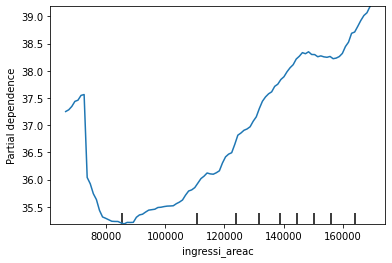

In [46]:
plot_partial_dependence(pm10_areac_normalizer.get_model(), pm10_areac_normalizer.get_trainingset(), ["ingressi_areac"])

L'andamento mostrato dal grafico è sicuramente particolare, perchè non mostra una relazione così evidente come quella vista per gli altri inquinanti.  
Sicuramente il nostro modello associa un aumento delle concentrazioni all'aumentare del traffico, come si può vedere dalla tendenza generale del grafico ottenuto. È però anche vero che non ci sia una relazione proprio così netta e quantitativamente l'aumento è comunque piuttosto ridotto.  

Passiamo all'analisi della serie normalizzata, anche se visto che il nostro modello ha associato un'importanza piuttosto bassa alla variabile non ci aspettiamo di ottere molta differenza rispetto a quanto visto in precedenza.

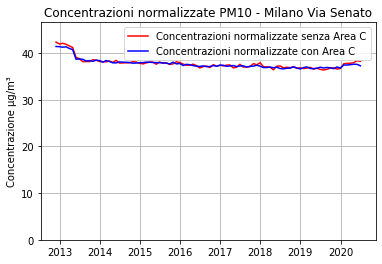

In [47]:
#milano_pm10_norm_areac = pm10_areac_normalizer.normalize_timeseries()
#milano_pm10_norm_areac.to_csv(path + "Milano_10320_PM10_areac_normalizzato.csv")
milano_pm10_norm_areac = pd.read_csv(path + "Milano_10320_PM10_areac_normalizzato.csv", parse_dates=["Data"], index_col="Data")

milano_pm10_mesenorm_areac = milano_pm10_norm_areac.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_pm10_mesenorm.inquinante), max(milano_pm10_mesenorm_areac.inquinante)])

plt.plot(milano_pm10_mesenorm.index, milano_pm10_mesenorm.inquinante, color="red", label="Concentrazioni normalizzate senza Area C")
plt.plot(milano_pm10_mesenorm_areac.index, milano_pm10_mesenorm_areac.inquinante, color="blue", label="Concentrazioni normalizzate con Area C")
plt.title("Concentrazioni normalizzate PM10 - Milano Via Senato")
plt.ylabel("Concentrazione µg/m³")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Vediamo infatti come le due serie rimangano praticamente sempre equivalenti, non mostrando particolari scostamenti neanche nel periodo dell'epidemia di COVID.  

Per quanto riguarda le polveri sottili, quindi, il nostro metodo non rileva una particolare influenza dell'andamento del traffico sulle concentrazioni registrate, anche se rimane comunque un lievissimo trend negativo sulla serie. **rivedi**

### O3
Proviamo a condurre le stesse analisi viste in precedenza anche per un inquinante come l'ozono che non è direttamente collegato al traffico, per vedere come si comportano i nostri modelli nella trattazione di questo particolare inquinante.

In [48]:
#ozono - Milano via Verziere
#o3_areac = data_prep.prepare_data(5725,2001,2006,14390,14391,2002,2008, use_areac=True)
#o3_areac.to_csv(path + "Milano_5725_O3_areac.csv")

o3_areac = pd.read_csv(path + "Milano_5725_O3_areac.csv", parse_dates=["Data"], index_col="Data")

In [49]:
o3_areac_normalizer = AirNormalizer(o3_areac)
print(o3_areac_normalizer.evaluate_training())
print(o3_areac_normalizer.evaluate_testing())

MSE          11.604456
RMSE          3.406531
OOB Score     0.910026
dtype: float64
MSE     82.162337
RMSE     9.064344
R2       0.906933
dtype: float64


Vediamo come le prestazioni del modello ottenuto rimangano molto buone, compatibilmente con quanto già visto in precedenza. L'ozono rimane infatti l'inquinante che i nostri modelli riescono a trattare meglio di tutti.

In [50]:
o3_areac_normalizer.feature_importance()

,cols,imp
5,radiazione,0.368476
0,temperatura,0.295040
7,day_of_year,0.105146
4,umidita,0.096847
3,velocita_vento,0.052084
6,ingressi_areac,0.025134
9,epoch,0.019654
2,direzione_vento,0.013625
8,day_of_week,0.009190
10,giorni_senza_pioggia,0.008696


L'importanza che viene associata al numero di ingressi in Area C è davvero molto bassa e quindi non possiamo aspettarci grandi differenze o grandi conclusioni trattando questo inquinante.

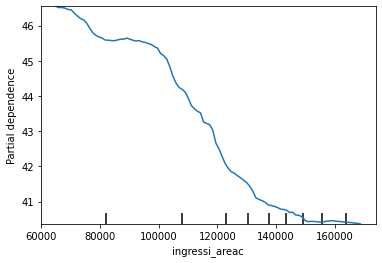

In [51]:
plot_partial_dependence(o3_areac_normalizer.get_model(), o3_areac_normalizer.get_trainingset(), ["ingressi_areac"])

Vedimao che il grafico mostra come per volumi maggiori di traffico le previsioni del nostro modello riportino valori più bassi. Questo, considerato che il traffico è maggiore nei mesi invernali proprio quando le concentrazioni di ozono sono minori, potrebbe farci pensare che il nostro modello usi questa variabile come ulteriore misura per spiegare l'andamento tipicamente stagionale dell'inquinante piuttosto che la sua reale correlazione col traffico.  

Creiamo anche il modello senza dataset di Area C in modo da poter poi confrontare le due serie ottenute e cercare possibili differenze.

In [52]:
o3_data = o3_areac.drop("ingressi_areac", axis=1)

o3_normalizer = AirNormalizer(o3_data)
print(o3_normalizer.evaluate_training())
print(o3_normalizer.evaluate_testing())

MSE          11.742177
RMSE          3.426686
OOB Score     0.908979
dtype: float64
MSE     81.858337
RMSE     9.047560
R2       0.907277
dtype: float64


In [53]:
o3_normalizer.feature_importance()

,cols,imp
5,radiazione,0.377423
0,temperatura,0.301135
6,day_of_year,0.110535
4,umidita,0.097364
3,velocita_vento,0.046046
8,epoch,0.024532
2,direzione_vento,0.015247
7,day_of_week,0.011539
9,giorni_senza_pioggia,0.009303
1,precipitazioni,0.006875


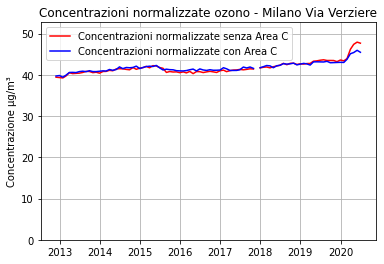

In [54]:
#milano_o3_norm_areac = o3_areac_normalizer.normalize_timeseries()
#milano_o3_norm_areac.to_csv(path + "Milano_5725_O3_areac_normalizzato.csv")
#milano_o3_norm = o3_normalizer.normalize_timeseries()
#milano_o3_norm.to_csv(path + "Milano_5725_O3_normalizzato.csv")
milano_o3_norm_areac = pd.read_csv(path + "Milano_5725_O3_areac_normalizzato.csv", parse_dates=["Data"], index_col="Data")
milano_o3_norm = pd.read_csv(path + "Milano_5725_O3_normalizzato.csv", parse_dates=["Data"], index_col="Data")

milano_o3_mesenorm_areac = milano_o3_norm_areac.groupby(pd.Grouper(freq="M")).mean()
milano_o3_mesenorm = milano_o3_norm.groupby(pd.Grouper(freq="M")).mean()

max_y = max([max(milano_o3_mesenorm.inquinante), max(milano_o3_mesenorm_areac.inquinante)])

plt.plot(milano_o3_mesenorm.index, milano_o3_mesenorm.inquinante, color="red", label="Concentrazioni normalizzate senza Area C")
plt.plot(milano_o3_mesenorm_areac.index, milano_o3_mesenorm_areac.inquinante, color="blue", label="Concentrazioni normalizzate con Area C")
plt.title("Concentrazioni normalizzate ozono - Milano Via Verziere")
plt.ylabel("Concentrazione µg/m³")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y / 10))
plt.show()

Vediamo che anche in questo caso le due serie ottenuti risultano praticamente identiche, riportando entrambi il trend in crescita già individuato in precedenza.  
Si nota inoltre come per il 2020 ci sia un'effettiva differenza sui valori delle previsioni fatte dai due modelli, con quello creato senza l'uso dei dati del traffico che tende a prevedere valori maggiori. In pratica sembra che i nostri modelli ci stiano dicendo che volumi minori di traffico potrebbero aver portato ad un aumento delle concentrazioni di ozono, che invece viene eliminato quando si considera anche il numero degli ingressi in Area C.  
Va però ricordato come l'ozono sia un inquinante molto complesso da anlizzare, poichè i processi che portano alla sua formazione possono essere svariati (ricordiamo infatti che l'ozono è un inquinante secondario) e può essere trasportato a grandi distanze e per molto tempo. Ciò rende quindi difficile attribuire un diretto collegamento tra traffico ed ozono, e quindi anche l'analisi dei risultati ottenuti, soprattutto considerata la scarsa importanza che viene associata alla variabile, deve tenere conto di tutti questi aspetti.  
In definitiva sembra comunque che gli andamenti del traffico non abbiano una grossa influenza sull'ozono, anche se rimarrebbe da verificare ulteriormente ed in modo più specifico l'episodio del 2020.

## Conclusioni
In questo notebook abbiamo quindi visto come la nostra tecnica, ma in generale qualsiasi valida alternativa ottenuta applicando diversi algoritmi di machine learning, possa essere utilizzata per analizzare le concentrazioni in modo più preciso avendole normalizzate rispetto agli effetti della meteorologia e della stagionalità. Questo quindi ci permette di controllarne meglio gli andamenti, verificando l'efficacia o l'effetto di diversi fattori.  
Il settore di cui ci siamo occupati, essendo uno dei più interessati e discussi quando si parla di inquinamento atmosferico, è il traffico, andando ad analizzare l'impatto dei provvedimenti Area C ed Area B presi nella città di Milano.

Dalle nostre analisi, fatte confrontando l'andamento della serie normalizzata di una stazione di Milano inclusa in Area C con quelle delle stazioni di Limito di Pioltello e Bormio, abbiamo verificato che l'adozioni di queste misure non ha portato a particolari miglioramenti della qualità dell'aria rispetto a quanto visto per le altre località. L'unico inquinante che sembra essere stato influenzato, almeno parzialmente, è il biossido di azoto, che è caratteristico del traffico veicolare. L'effetto rilevato è comunque ridotto e non è da escludere che sia anche da associare ad altri fattori.  
Per quanto riguarda monossido di carbonio e polveri sottili, invece, sembra che tali provvedimenti non abbiano avuto alcun effetto.

Abbiamo inoltre mostrato come la nostra tecnica, grazie all'adozione di random forest, sia particolarmente vantaggiosa quando si vogliono andare ad aggiungere variabili predittrici per il nostro modello.  
Abbiamo quindi integrato nei nostri dati le registrazioni degli ingressi in Area C, per provare ad eliminare dalle serie degli inquinanti gli effetti del traffico. Le serie ottenute in questo caso sono comunque risultate molto vicine a quelle già ottenute in precedenza, mostrando differenze di andamento solo per il periodo dell'epidemia di COVID-19. Questo ci ha dimostrato quindi come l'effetto delle variazioni nel volume del traffico, che sono sempre piuttosto scarse, abbiano effetti nulli sulle concentrazioni misurate, indicandoci perciò che per ottenere risultati apprezzabili sia necessario intervenire su larga scala, riducendo le emissioni prodotte in modo continuato.